In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/svendsem/Documents/MQED-QEDFT/flick_group/photonpilot')
from photonpilot.spherical import SphericalDGF

##  Test example of the spherical cavity

In [2]:
N = int(1E5)
hbar_eVs = 6.582E-16
c = 3E8

# Desired energy range in eV
emin = 0.1
emax = 17.1

# Frequencies in THz
omega = np.linspace(emin, emax, N)/hbar_eVs

# Drude parameters for gold
wp = 2.068E15*(2*np.pi)
g  = 5.513E12*(2*np.pi)
epsilon_gold = 1 - wp**2/(omega**2 + 1j*g*omega)


### Scaling with cavity radius

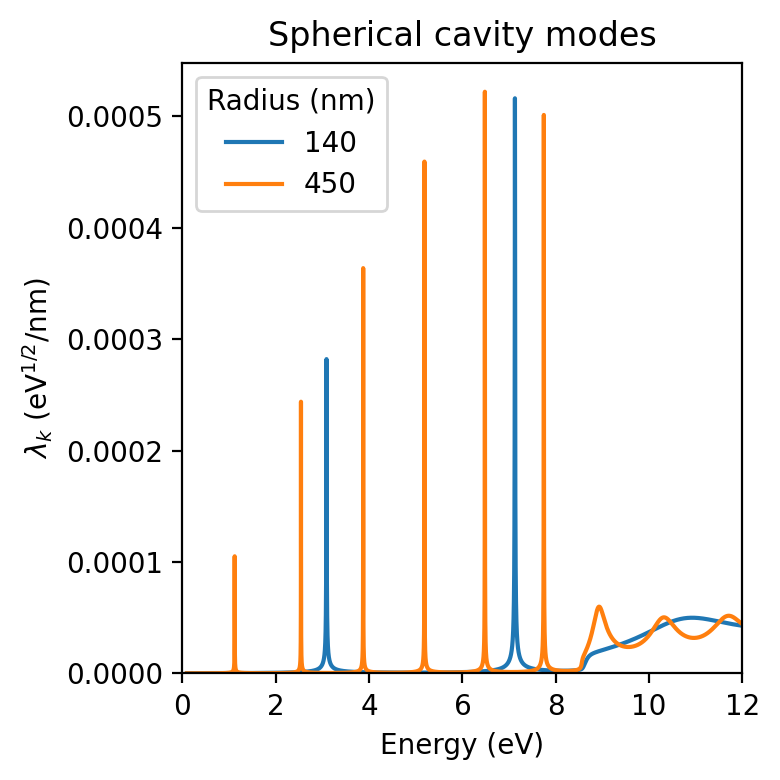

In [3]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 200)
for R in np.array([140, 450])*1E-9:
    DGF = SphericalDGF(R, omega, epsilon_gold)
    DGF.get_lambda2()
    ax.plot(omega*hbar_eVs, np.sqrt(DGF.lambda2), label = "{r:0.0f}".format(r=R*1E9))

ax.set_xlabel("Energy (eV)")
ax.set_xlim([0,12])
ax.set_ylabel("$\lambda_k$ (eV$^{1/2}$/nm)")
ax.set_ylim(bottom = 0)
ax.legend(title = "Radius (nm)")
ax.set_title("Spherical cavity modes")
fig.tight_layout()




### Scaling with cavity losses

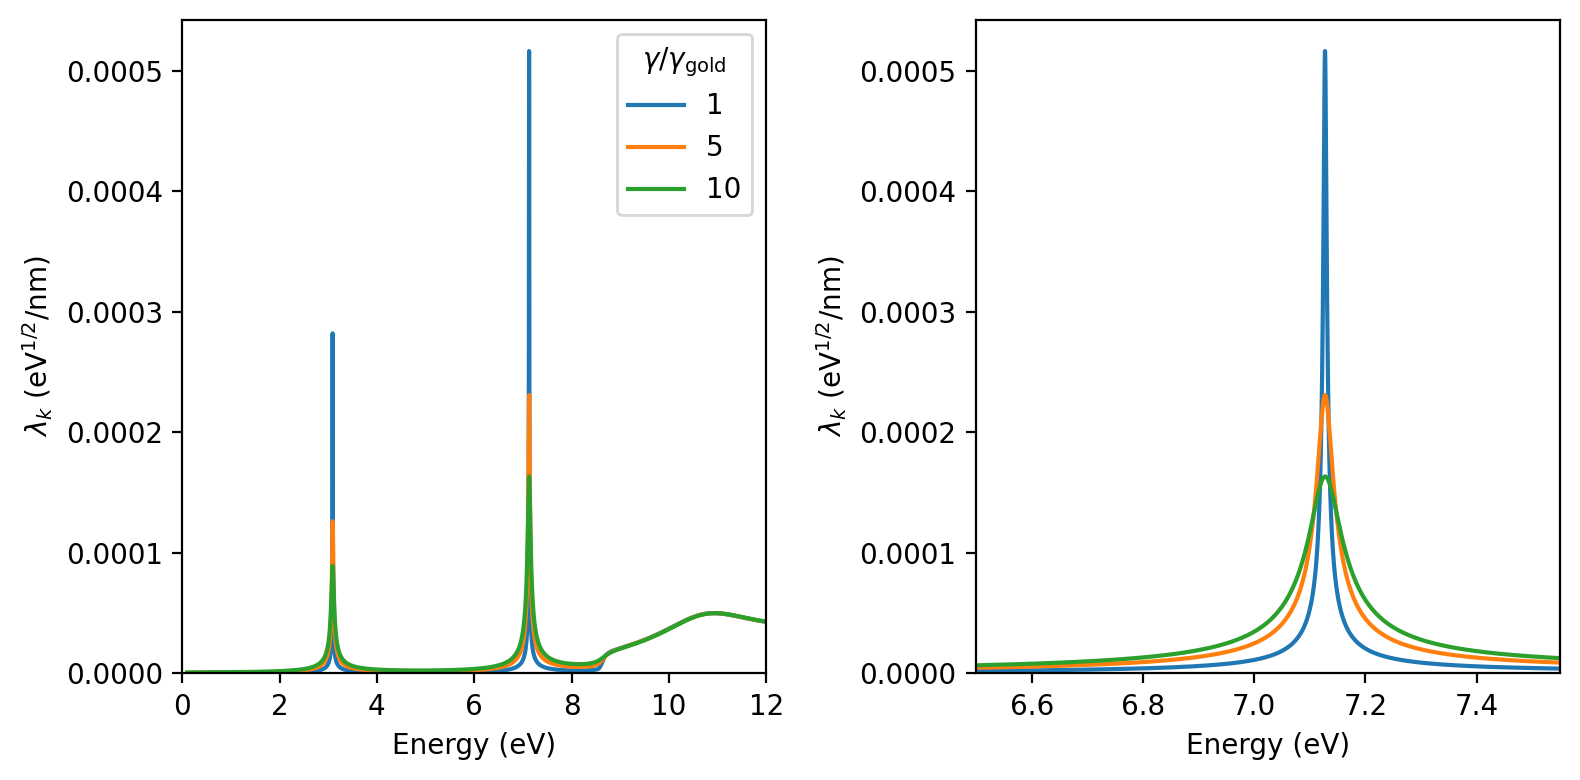

In [4]:
R = 140E-9
gammas = np.array([1, 5, 10])*g

fig, ax = plt.subplots(1,2, figsize = (8,4), dpi = 200)
for gamma in gammas:
    epsilon = 1 - wp**2/(omega**2 + 1j*gamma*omega)
    DGF = SphericalDGF(R, omega, epsilon)
    DGF.get_lambda2()

    ax[0].plot(omega*hbar_eVs, np.sqrt(DGF.lambda2), label = "{g:0.0f}".format(g=gamma/g))
    ax[1].plot(omega*hbar_eVs, np.sqrt(DGF.lambda2))


ax[0].set_xlim([0,12])
ax[0].set_ylim(bottom = 0)
ax[0].set_xlabel("Energy (eV)")
ax[0].set_ylabel("$\lambda_k$ (eV$^{1/2}$/nm)")
ax[0].legend(title="$\gamma/\gamma_\mathrm{gold}$")

ax[1].set_xlim([6.5, 7.55])
ax[1].set_ylim(bottom = 0)
ax[1].set_xlabel("Energy (eV)")
ax[1].set_ylabel("$\lambda_k$ (eV$^{1/2}$/nm)")
fig.tight_layout()


### Packaging parameters for octopus
Here we show an example of how to package the photon modes for use in the Octopus Casida code

In [5]:
r_list = np.array([15.97*0.9875])*1E-9
Ns = np.array([1E3]).astype('int64')

# Desired energy range in eV
emin = 0.1
emax = 17.1

for N in Ns:
    for r in r_list:
        # Constants for conversion to octopus units
        eVPerAU = 27.211 #27.211 eV per Hartree
        nmPerBohr = 0.0529 # 0.0529 nm per Bohr

        # Frequencies in THz
        omega = np.linspace(emin, emax, N)/hbar_eVs
        epsilon_gold = 1 - wp**2/(omega**2 + 1j*g*omega)

        # Getting the modes
        DGF = SphericalDGF(R, omega, epsilon_gold)
        DGF.get_lambda2()
        lambda2 = np.copy(DGF.lambda2)
        omega = omega*hbar_eVs # Converting to eV

        # Finding the relevant modes (Removing irrelevant zero modes)
        min_scale = 1E-7 # Can be set to what you want but one should converge this in the calculations
        relevant_lambdas = lambda2[lambda2 > min_scale*np.max(lambda2)]
        relevant_omegas = omega[lambda2 > min_scale*np.max(lambda2)]
        print('Number of relevant modes {}'.format(3*len(relevant_lambdas)))

        relevant_lambdas = np.sqrt(relevant_lambdas)
        
        # Unit conversion
        wArray = np.real(relevant_omegas/eVPerAU)
        lambdaArray = np.real(relevant_lambdas*nmPerBohr/np.sqrt(eVPerAU))

        # Preparing the output array
        numModes = 0
        outputArray = []
        for i in range(0,len(wArray)):
            # Spherical symmetry means that we get something in all directions
            outputArray.append([wArray[i],lambdaArray[i],1,0,0])
            outputArray.append([wArray[i],lambdaArray[i],0,1,0])
            outputArray.append([wArray[i],lambdaArray[i],0,0,1])
            numModes = numModes + 3
        
        # Packaging the modes
        outputname = 'spherical_cavity_R={r:0.0f}nm_N_{n}'.format(r=r*1E9, n = N)
        f = open(outputname, 'w')
        string = '{} 5\n'.format(numModes)
        f.write(string)
        for i in range(0,len(outputArray)):
            string = '%2.15f  %2.15f  %2.15f  %2.15f  %2.15f\n' % \
            (outputArray[i][0], outputArray[i][1], outputArray[i][2], outputArray[i][3], outputArray[i][4])
            f.write(string)
        f.close()



Number of relevant modes 3000


## Purcell enhancement
Below we provide a simple example of how the Purcell enhancement can be calculated

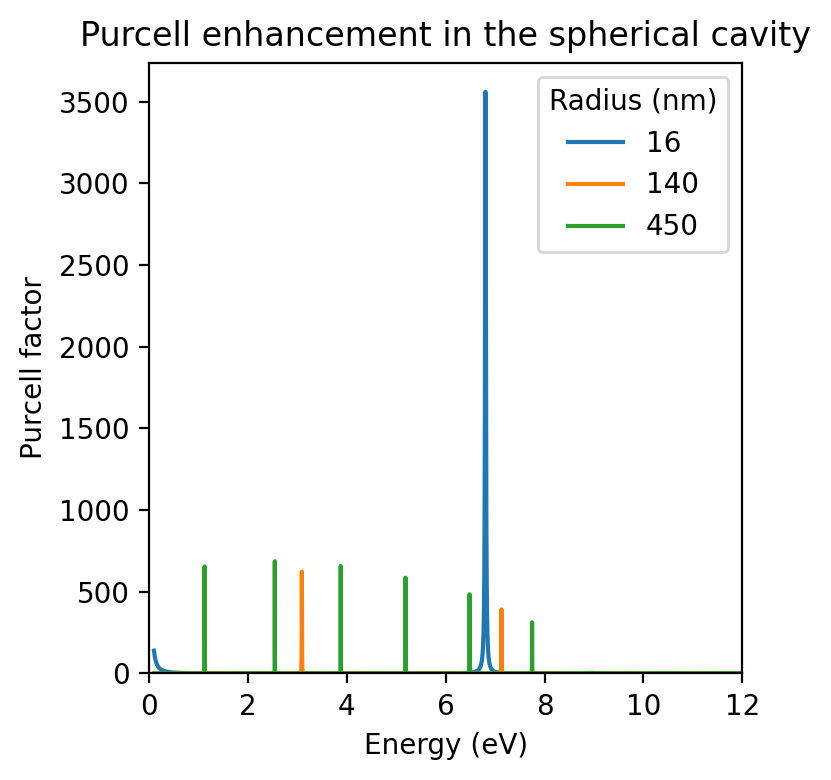

In [6]:
# Desired energy range in eV
emin = 0.1
emax = 17.1
N = int(1E5)


# Frequencies in THz
omega = np.linspace(emin, emax, N)/hbar_eVs
epsilon_gold = 1 - wp**2/(omega**2 + 1j*g*omega)


fig, ax = plt.subplots(figsize = (4,4), dpi = 200)
for R in np.array([16, 140, 450])*1E-9:
    DGF = SphericalDGF(R, omega, epsilon_gold)
    DGF.get_DGF()

    pf = 6*np.pi*(c/omega)*np.imag(DGF.DGF)

    ax.plot(omega*hbar_eVs, pf, label = "{r:0.0f}".format(r=R*1E9))

ax.set_xlabel("Energy (eV)")
ax.set_xlim([0,12])
ax.set_ylabel("Purcell factor")
ax.set_ylim(bottom = 0)
ax.legend(title = "Radius (nm)")
ax.set_title("Purcell enhancement in the spherical cavity")
fig.tight_layout()